# Using `dask` with Scanpy

:::{warning}
🔪Beware sharp edges!🔪

`dask` support in `scanpy` is new and highly experimental!

Many functions in `scanpy` *do not* support `dask` and may exhibit unexpected behaviour if dask arrays are passed to them. Stick to what's outlined in this tutorial and you should be fine!

Please report any issues you run into over on the issue tracker.
:::

`dask` is a popular out-of-core, distributed array processing library that scanpy is beginning to support.  Here we walk through a quick tutorial of using `dask` in a simple analysis task.

In [2]:
import numpy as np
import dask.distributed as dd
import dask.array as da
import scanpy as sc
import anndata as ad
import h5py
from scipy import sparse
from pathlib import Path

sc.logging.print_header()

scanpy==1.10.0rc2.dev19+ga6126980 anndata==0.10.6 umap==0.5.5 numpy==1.26.3 scipy==1.12.0 pandas==2.2.1 scikit-learn==1.4.0 statsmodels==0.14.1 igraph==0.11.3 pynndescent==0.5.11


In [3]:
if not Path("cell_atlas.h5ad").exists():
    !wget https://datasets.cellxgene.cziscience.com/82eac9c1-485f-4e21-ab21-8510823d4f6e.h5ad -O "cell_atlas.h5ad"

--2024-03-20 14:43:09--  https://datasets.cellxgene.cziscience.com/82eac9c1-485f-4e21-ab21-8510823d4f6e.h5ad
Resolving datasets.cellxgene.cziscience.com (datasets.cellxgene.cziscience.com)... 18.64.79.73, 18.64.79.72, 18.64.79.109, ...
Connecting to datasets.cellxgene.cziscience.com (datasets.cellxgene.cziscience.com)|18.64.79.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13979243997 (13G) [binary/octet-stream]
Saving to: ‘cell_atlas.h5ad’

cell_atlas.h5ad     100%[===================>]  13.02G   323MB/s    in 49s     

2024-03-20 14:43:59 (275 MB/s) - ‘cell_atlas.h5ad’ saved [13979243997/13979243997]



For more information on using distributed computing via `dask`, please see their [documentation](https://docs.dask.org/en/stable/deploying-python.html).  For example, `dask` provides direct support for [slurm](https://jobqueue.dask.org/en/latest/).  In short, one needs to define both a cluster and a client to have some degree of control over the compute resources dask will use.

In [3]:
cluster = dd.LocalCluster(n_workers=3)
client = dd.Client(cluster)

In [6]:
SPARSE_CHUNK_SIZE = 100_000
DENSE_CHUNK_SIZE = 10_000

Dask provides extensive tooling for monitoring your computation. You can access that via the dashboard started when using any of their distributed clusters.

In [4]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 3
Total threads: 18,Total memory: 62.79 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41827,Workers: 3
Dashboard: http://127.0.0.1:8787/status,Total threads: 18
Started: Just now,Total memory: 62.79 GiB
Comm: tcp://127.0.0.1:43981,Total threads: 6
Dashboard: http://127.0.0.1:36913/status,Memory: 20.93 GiB
Nanny: tcp://127.0.0.1:45967,


We'll convert the `X` representation to `dask`.  For more info on i/o from disk, please see the `anndata` tutorials, e.g. [here](https://anndata.readthedocs.io/en/latest/tutorials/notebooks/anndata_dask_array.html) or [here](https://anndata.readthedocs.io/en/latest/tutorials/notebooks/%7Bread%2Cwrite%7D_dispatched.html).  For now, simply converting `X` will be enough to demonstrate the functionality of scanpy with dask.

**_Important Note:_** At the moment, scanpy only works with dense, `np.array` chunks in `dask` arrays.  Sparse support is a work in progress, and this tutorial will be updated accordingly when possible. 

**TODO** Modify text to say reading zarr is easier

**_Important Note:_** Pay close attention to our use of `xarray.backends.CachingFileManager` - this is needed as `dask` cannot handle pickling an `h5py.File` object!  When writing your data, it is thus advisale to use `zarr`.

In [7]:
def read_sparse_as_dask(file_pth: str, elem_name: str, stride: int):
    with h5py.File(file_pth, "r") as f:
        elem = f[elem_name]
        shape = elem.attrs["shape"]
        if (encoding_type := elem.attrs["encoding-type"]) != "csr_matrix":
            raise ValueError(
                f"This method was only written for csr_matrix encoding, but a {encoding_type} encoding was found."
            )
        dtype = elem["data"].dtype

    def make_dask_chunk(block_id=None):
        # We need to open the file in each task since `dask` cannot share h5py objects when using `dask.distributed`
        # https://github.com/scverse/anndata/issues/1105
        with h5py.File(file_pth, "r") as f:
            mtx = ad.experimental.sparse_dataset(f[elem_name])
            (row, _) = block_id
            chunk = mtx[
                slice(
                    row * stride,
                    min((row * stride) + stride, shape[0]),
                )
            ]
        return chunk

    chunks_0 = (stride,) * (shape[0] // stride)
    chunks_0 += (shape[0] % stride,)
    chunks_1 = (shape[1],)
    da_mtx = da.map_blocks(
        make_dask_chunk,
        dtype=dtype,
        chunks=(chunks_0, chunks_1),
        meta=sparse.csr_matrix((0, 0), dtype=np.float32),
    )
    return da_mtx

The file we've retrieved from cellxgene has already been processed. We will read in just the annotations and count matrix for the purpose of this tutorial.

In [9]:
%%time
with h5py.File("cell_atlas.h5ad", "r") as f:
    adata = ad.AnnData(
        obs=ad.experimental.read_elem(f["obs"]),
        var=ad.experimental.read_elem(f["var"]),
    )

adata.X = read_sparse_as_dask("cell_atlas.h5ad", "raw/X", SPARSE_CHUNK_SIZE)
adata

CPU times: user 2.6 s, sys: 355 ms, total: 2.96 s
Wall time: 2.89 s


AnnData object with n_obs × n_vars = 1462702 × 27714
    obs: 'celltype', 'majorType', 'City', 'sampleID', 'donor_id', 'Sample type', 'CoVID-19 severity', 'Sample time', 'Sampling day (Days after symptom onset)', 'BCR single cell sequencing', 'TCR single cell sequencing', 'Outcome', 'Comorbidities', 'COVID-19-related medication and anti-microbials', 'Leukocytes [G over L]', 'Neutrophils [G over L]', 'Lymphocytes [G over L]', 'Unpublished', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length'

We've optimized a number of scanpy functions to be completley lazy. That means it will look like nothing is computed when you call an operation on a dask array, but only later when you hit compute.

In some cases it's currently unavoidable to skip all computation, and these cases will kick off compute for all the delayed operations immediatley.

In [11]:
%%time
sc.pp.normalize_total(adata, target_sum=1e4)

CPU times: user 11.2 ms, sys: 0 ns, total: 11.2 ms
Wall time: 10.9 ms


In [12]:
%%time
sc.pp.log1p(adata)

CPU times: user 4.64 ms, sys: 0 ns, total: 4.64 ms
Wall time: 4.53 ms


It can be useful to cache data, so computations don't need to be repeated.

In [8]:
# import zarr

# adata_dask.X = adata_dask.X.to_zarr("cell_atlas_normalized_X.zarr", storage_options={"consolidated": True, "compressor": zarr.Zstd()}, return_stored=True, overwrite=True)

In [13]:
adata.X

dask.array<log1p, shape=(1462702, 27714), dtype=float32, chunksize=(100000, 27714), chunktype=scipy.csr_matrix>

Highly variable genes needs to add entries into `obs`, which currently does not support lazy column. So computation will occur immediatly on call.

In [14]:
%%time
sc.pp.highly_variable_genes(adata)

PCA currently does not support sparse data. So we will need to densify the expression matrix before passing it in. However, as we are working with only a subset of the data at a time we are able to perform this operation with a lower memory overhead.

As this is a still a signifigant increase in memory usage per chunk, we will need to reduce the number of observations present in each chunk.

In [15]:
adata.layers["dense"] = adata.X.rechunk((DENSE_CHUNK_SIZE, -1)).map_blocks(lambda x: x.toarray(), dtype=adata.X.dtype, meta=np.array([]))

In [16]:
%%time
sc.pp.pca(adata, layer="dense")

2024-03-21 12:15:07,407 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 17.10 GiB -- Worker memory limit: 20.93 GiB
2024-03-21 12:15:08,918 - distributed.worker.memory - WARNING - Worker is at 68% memory usage. Resuming worker. Process memory: 14.26 GiB -- Worker memory limit: 20.93 GiB


CPU times: user 12.7 s, sys: 1.15 s, total: 13.9 s
Wall time: 1min 46s


While most of the PCA computation runs immediatley, the last step (computing the observation loadings) is lazy, so must be triggered manually to avoid recomputation.

In [18]:
%%time
adata.obsm["X_pca"] = adata.obsm["X_pca"].compute()

CPU times: user 10 s, sys: 1.25 s, total: 11.3 s
Wall time: 1min 34s


In [19]:
adata

AnnData object with n_obs × n_vars = 1462702 × 27714
    obs: 'celltype', 'majorType', 'City', 'sampleID', 'donor_id', 'Sample type', 'CoVID-19 severity', 'Sample time', 'Sampling day (Days after symptom onset)', 'BCR single cell sequencing', 'TCR single cell sequencing', 'Outcome', 'Comorbidities', 'COVID-19-related medication and anti-microbials', 'Leukocytes [G over L]', 'Neutrophils [G over L]', 'Lymphocytes [G over L]', 'Unpublished', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'highly_variable', '

Now that we've computed our PCA let's take a look at it:

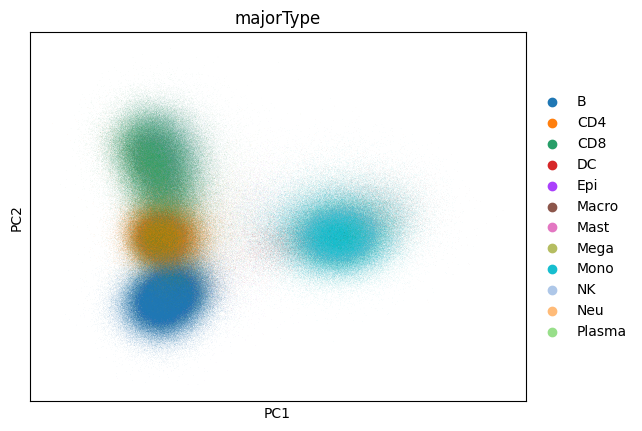

In [20]:
sc.pl.pca(adata, color="majorType")

In [21]:
%%time
# This is just a bit extra to delete later. Looking at how much faster we can make the whole pipeline:
from sklearn_ann.kneighbors.annoy import AnnoyTransformer

transformer = AnnoyTransformer(n_neighbors=15)
sc.pp.neighbors(adata, transformer=transformer)
# 1m 23.5s

CPU times: user 1min 47s, sys: 2.25 s, total: 1min 49s
Wall time: 1min 27s


In [22]:
sc.tl.leiden(adata, flavor="igraph", n_iterations=2)
# 2m 37.5s

UMAP computation can be slow however:

In [24]:
# %%time
# sc.tl.umap(adata)
# sc.pl.umap(adata, color=["leiden", "majorType"])

IOStream.flush timed out
IOStream.flush timed out
2024-03-21 12:51:57,497 - distributed.worker - WARNING - Scheduler was unaware of this worker; shutting down.
2024-03-21 12:52:15,065 - distributed.worker - WARNING - Scheduler was unaware of this worker; shutting down.


2024-03-21 12:53:18,819 - distributed.core - INFO - Connection to tcp://127.0.0.1:43869 has been closed.
2024-03-21 12:53:18,832 - distributed.core - INFO - Connection to tcp://127.0.0.1:43869 has been closed.
2024-03-21 12:53:20,821 - distributed.nanny - ERROR - Worker process died unexpectedly
2024-03-21 12:53:20,835 - distributed.nanny - ERROR - Worker process died unexpectedly


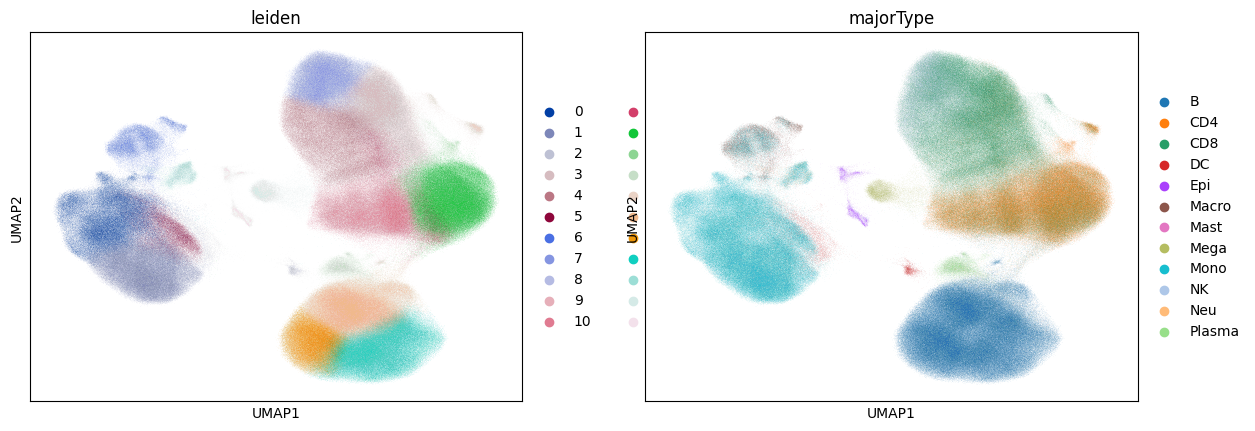